# Improving Remote Poverty Detection with Multiview Learning
## SETUP

In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')
! pip install geoio

Mounted at /content/drive
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 23.7MB 1.7MB/s 
  Created wheel for tzwhere: filename=tzwhere-3.0.3-cp37-none-any.whl size=23742584 sha256=f658b23e265336c1338433e4aaae52e6b60632dd0fd2c9ca1d6c881f5da2b4d9
  Stored in directory: /root/.cache/pip/wheels/89/18/2f/01c958c82b1223d6fe763c6b2fadf45b4f6ce6e8a9fce7bbd5
Successfully built tzwhere


In [ ]:
! cp drive/MyDrive/detecting-poverty/data ./ -r

In [ ]:
! ls data/landsat/eth | wc -l
print("Enthiopia Landsat Images")

8526
Enthiopia Landsat Images


In [ ]:
! ls data/landsat/mw | wc -l
print("Malawi Landsat Images")

12459
Malawi Landsat Images


In [ ]:
! ls data/landsat/ng | wc -l
print("Nigeria Landsat Images")

3733
Nigeria Landsat Images


In [ ]:
! cp drive/MyDrive/detecting-poverty/modules/* ./

In [ ]:
# ! rm *.py

In [ ]:
! ls

data  drive  __pycache__  sample_data


In [ ]:
import numpy as np
import torch
import pandas as pd
import random
import json
from data_loaders import LandsatViirs, LandsatTransform, ViirsTransform
from conv_ved import ConvVED, Landsat2ViirsNet, LandsatCvaeNet, conved_for_prediction
from predictors import elastic_net, logistic
import utils
from utils import confusion_matrix, adjusted_classes
from sklearn.model_selection import train_test_split
import geoio
import matplotlib.pyplot as plt
%matplotlib inline
from utils import create_space
import os
from PIL import Image, ImageFile
import torchvision.transforms.functional as TF

In [ ]:
# import importlib
# importlib.reload()

NameError: ignored

In [ ]:
torch.random.manual_seed(31220)
random.seed(31220)
ImageFile.LOAD_TRUNCATED_IMAGES = True

## The DATA
### Survey and Reference Data

In [ ]:
full_reference_data = pd.read_csv('data/image_download_actual.csv')
print(full_reference_data.shape)
full_reference_data.head(3)

(24714, 10)


,image_name,image_lat,image_lon,cluster_lat,cluster_lon,cons_pc,nightlights,country,nightlights_bin,is_train
0,-17.09515_35.17229723579403_-17.09515_35.21721...,-17.095150,35.172297,-17.09515,35.217213,1.423239,0.025206,mw,0,True
1,-17.08017807859801_35.17229723579403_-17.09515...,-17.080178,35.172297,-17.09515,35.217213,1.423239,0.025206,mw,0,True
2,-17.125093842803985_35.18726915719602_-17.0951...,-17.125094,35.187269,-17.09515,35.217213,1.423239,0.025206,mw,0,False


In [ ]:
full_reference_data.country.value_counts()

mw     12456
eth     8525
ng      3733
Name: country, dtype: int64

### VIRS

In [ ]:
NIGHTLIGHTS_DIRS = ['data/viirs/viirs_2015_' + tif_name for tif_name in ['00N060W.tif', '75N060W.tif']]
viirs_tifs = [geoio.GeoImage(ndir) for ndir in NIGHTLIGHTS_DIRS]

In [ ]:
viirs_tifs[0]

Class Name        : GeoImage
Driver Name       : GTiff
Data Type         : Float32
File Name         : data/viirs/viirs_2015_00N060W.tif
File List         : ['data/viirs/viirs_2015_00N060W.tif']
Dimensions        : (1, 28800, 15600) (nlayers, nrows, ncols)
Resolution        : (0.0041666667, 0.0041666667) (x,y)
Extent            : (-60.00208333335, 0.00208333335, 59.99791762665001,
                    -64.99791718665) (ul_x, ul_y, lr_x, lr_y)
Projection String : GEOGCS["WGS 84",
                     DATUM["WGS_1984",
                         SPHEROID["WGS 84",6378137,298.257223563,
                             AUTHORITY["EPSG","7030"]],
                         AUTHORITY["EPSG","6326"]],
                     PRIMEM["Greenwich",0],
                     UNIT["degree",0.0174532925199433],
                     AUTHORITY["EPSG","4326"]]
Geo Transform     : (-60.00208333335, 0.0041666667, 0.0, 0.00208333335, 0.0,
                    -0.0041666667)
Authority         : EPSG:4326

In [ ]:
# VIIRS TRANSFORMER
viirs_transform = ViirsTransform(viirs_tifs)

In [ ]:
print("The brightest pixel in all our VIIRS tiles.")
print(max(viirs_transform.arrays['mw'].max(), viirs_transform.arrays['eth'].max()))

The brightest pixel in all our VIIRS tiles.
92682.27


In [ ]:
viirs_transform.arrays['eth'].shape

(1, 18000, 28800)

In [ ]:
# TRANSFORMED SAMPLE
lat, lon, country = full_reference_data.loc[19675,['image_lat', 'image_lon', 'country']]
viirs_tensor = viirs_transform((lat, lon), 'eth')
print(viirs_tensor)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0176, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0180,
          0.0218, 0.0246, 0.0316, 0.0337, 0.0369],
     

### LANDSAT
#### RAW

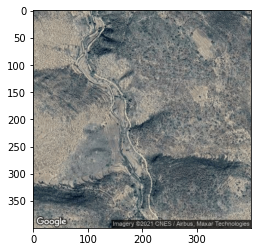

In [ ]:
# LANDSAT SAMPLE
img = Image.open("data/landsat/eth/9.580860504393984_42.067393444198004_9.55091666159_42.0823653656.png")
# ! ls data/landsat/'ethiopia_imgs.zip (Unzipped Files)'/'images copy'
plt.imshow(img)

#### Resized

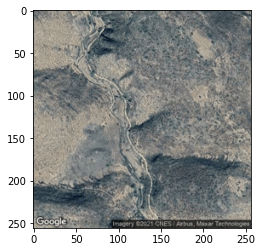

In [ ]:
plt.imshow(img.resize((256, 256)))

#### As Tensor

In [ ]:
TF.pil_to_tensor(img.convert('RGB'))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:169: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)



tensor([[[116, 100, 131,  ..., 108, 156, 172],
         [ 92,  73,  89,  ..., 143, 122,  91],
         [100, 108, 104,  ..., 122, 104,  96],
         ...,
         [187, 165, 187,  ...,  50,  50,  50],
         [182, 165, 181,  ...,  56,  48,  50],
         [181, 156, 182,  ...,  50,  48,  50]],

        [[124, 108, 139,  ..., 108, 150, 164],
         [100,  83,  99,  ..., 139, 121,  90],
         [108, 112, 108,  ..., 121, 104,  96],
         ...,
         [179, 158, 183,  ...,  48,  48,  48],
         [178, 156, 173,  ...,  54,  46,  48],
         [173, 150, 178,  ...,  48,  46,  48]],

        [[128, 108, 139,  ..., 104, 139, 149],
         [100,  89, 104,  ..., 131, 115,  90],
         [108, 116, 112,  ..., 115, 100,  96],
         ...,
         [163, 148, 171,  ...,  45,  45,  45],
         [166, 141, 163,  ...,  50,  42,  45],
         [163, 139, 166,  ...,  45,  42,  45]]], dtype=torch.uint8)

#### As Transformed Tensor

In [ ]:
landsat_transform = LandsatTransform('data/landsat')
image_name, country = full_reference_data.loc[17202,['image_name', 'country']]
t = landsat_transform(image_name, country)
print(t)

tensor([[[0.4745, 0.3059, 0.2941,  ..., 0.5804, 0.5804, 0.5804],
         [0.4745, 0.3882, 0.3608,  ..., 0.5412, 0.5333, 0.5412],
         [0.5098, 0.4157, 0.4157,  ..., 0.5098, 0.5059, 0.5137],
         ...,
         [0.5059, 0.4588, 0.5608,  ..., 0.2118, 0.0627, 0.0549],
         [0.4863, 0.5216, 0.5765,  ..., 0.0588, 0.0588, 0.0549],
         [0.4706, 0.4784, 0.5020,  ..., 0.0824, 0.0588, 0.0549]],

        [[0.4745, 0.3176, 0.3098,  ..., 0.5608, 0.5647, 0.5686],
         [0.4549, 0.3882, 0.3686,  ..., 0.5333, 0.5294, 0.5294],
         [0.4863, 0.4157, 0.4235,  ..., 0.4980, 0.4980, 0.5020],
         ...,
         [0.4706, 0.4353, 0.5373,  ..., 0.2157, 0.0706, 0.0588],
         [0.4353, 0.4824, 0.5490,  ..., 0.0627, 0.0667, 0.0627],
         [0.4235, 0.4431, 0.4706,  ..., 0.0824, 0.0667, 0.0627]],

        [[0.4471, 0.3020, 0.3059,  ..., 0.5098, 0.5098, 0.5098],
         [0.4353, 0.3686, 0.3569,  ..., 0.4784, 0.4706, 0.4706],
         [0.4549, 0.3922, 0.4000,  ..., 0.4471, 0.4510, 0.

## MODEL — Convolution Variational Encoder-Decoder
### Data Pipeline

In [ ]:
# create dataset objects
ref_features = ['image_lat', 'image_lon', 'image_name', 'country']
target = 'cons_pc'

traindev_ref_data, test_ref_data, Ytraindev, Ytest = train_test_split(
    full_reference_data[ref_features],
    full_reference_data[target],
    train_size=0.9
)

train_ref_data, dev_ref_data, Ytrain, Ydev = train_test_split(
    traindev_ref_data,
    Ytraindev,
    train_size=0.9
)

viirs_transform = ViirsTransform(viirs_tifs)
landsat_transform = LandsatTransform('data/landsat')

training_loader = LandsatViirs(
    df=train_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
dev_loader = LandsatViirs(
    df=dev_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
test_loader = LandsatViirs(
    df=test_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)

### Trial Run

In [ ]:
small_train_ref_data = train_ref_data.sample(1000)
small_training_loader = LandsatViirs(
    df=small_train_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
small_dev_ref_data = dev_ref_data.sample(100)
small_dev_loader = LandsatViirs(
    df=small_dev_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
score, _, _ = conved_for_prediction(
    small_training_loader,
    small_dev_loader,
    Ytrain[small_train_ref_data.index],
    Ydev[small_dev_ref_data.index],
    n_components=32,
    lr=2e-3,
    kkl=1,
    kv=1,
    path="ConvVED_test.pt",
    batch_size=512,
    epochs=3
)


Using Convolutional VED
32 Components
0.002 Learning Rate
1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 280.8234, dev loss: 274.0074
Epoch: 2, train loss: 272.2751, dev loss: 263.7075
Epoch: 3, train loss: 261.4771, dev loss: 249.3530

Training Elastic Net



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.48583221435547, tolerance: 41.66653060913086



{
    "R2": 0.04316701403938872,
    "alpha": 2.8538093043190686e-05,
    "l1_ratio": 0.9
}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.48296356201172, tolerance: 40.834171295166016



## Model Experimentation for Downstream Regression Predicting Household Consumption


In [ ]:
# Hyperparameter Search Space
n_components_cands = [16, 32, 64]
lr_cands = [1e-3]
kkl_cands = [0.1, 1]
kv_cands = [1, 10]

results_set = []
best_score = 0
i = -1

# Grid Search
for n_components in n_components_cands:
  for lr in lr_cands:
    for kkl in kkl_cands:
      for kv in kv_cands:
        i += 1
        score, cved, enet = conved_for_prediction(
            training_loader,
            dev_loader,
            Ytrain,
            Ydev,
            n_components=n_components,
            lr=lr,
            kkl=kkl,
            kv=kv,
            path=f"ConvVED{i}.pt",
            batch_size=512
        )
        results_set.append({
            "model_index" : i,
            "R2" : score,
            "n_components" : n_components,
            "learning_rate" : lr,
            "kkl" : kkl,
            "kv" : kv
        })
        if score > best_score:
          best_score = score
          best_model = {
              'cved' : cved,
              'enet' : enet
          }
          best_i = i


Using Convolutional VED
16 Components
0.001 Learning Rate
0.1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 156.7992, dev loss: 69.7377
Epoch: 2, train loss: 65.7574, dev loss: 60.8747
Epoch: 3, train loss: 61.6923, dev loss: 58.3195
Epoch: 4, train loss: 59.4604, dev loss: 57.1093
Epoch: 5, train loss: 58.7143, dev loss: 55.8626
Epoch: 6, train loss: 58.9037, dev loss: 55.5135
Epoch: 7, train loss: 58.1083, dev loss: 55.2713
Epoch: 8, train loss: 57.8611, dev loss: 56.8242
Epoch: 9, train loss: 58.0961, dev loss: 53.4383
Epoch: 10, train loss: 56.9876, dev loss: 54.3614

Training Elastic Net

{
    "R2": 0.10157300666607683,
    "alpha": 0.0011257968812446919,
    "l1_ratio": 1.0
}

Using Convolutional VED
16 Components
0.001 Learning Rate
0.1 KL Divergence Regularizer
10 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 181.8379, dev loss: 81.6721
Epoch: 2, train loss: 76.8888, dev loss: 71.1095
Epoch: 3, train loss: 70

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1435.2509765625, tolerance: 840.3350219726562

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 17359.23828125, tolerance: 840.3350219726562

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678.56787109375, tolerance: 855.1803588867188

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1250.427734375, tolerance: 855.1803588867188

/

{
    "R2": 0.09893229993848562,
    "alpha": 0.0015304931225188442,
    "l1_ratio": 1.0
}

Using Convolutional VED
32 Components
0.001 Learning Rate
0.1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 188.0282, dev loss: 77.4553
Epoch: 2, train loss: 70.2621, dev loss: 62.5771
Epoch: 3, train loss: 62.6577, dev loss: 59.0878
Epoch: 4, train loss: 60.2713, dev loss: 58.2856
Epoch: 5, train loss: 59.7237, dev loss: 58.7037
Epoch: 6, train loss: 58.8477, dev loss: 56.2492
Epoch: 7, train loss: 58.4532, dev loss: 56.3333
Epoch: 8, train loss: 58.5487, dev loss: 55.8106
Epoch: 9, train loss: 58.2744, dev loss: 56.1179
Epoch: 10, train loss: 57.7868, dev loss: 55.9427

Training Elastic Net

{
    "R2": 0.07928782215625674,
    "alpha": 0.0008201164752148174,
    "l1_ratio": 1.0
}

Using Convolutional VED
32 Components
0.001 Learning Rate
0.1 KL Divergence Regularizer
10 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 163.8360, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30688.0625, tolerance: 1048.61962890625



Epoch: 1, train loss: 185.8452, dev loss: 83.5141
Epoch: 2, train loss: 78.6123, dev loss: 70.8380
Epoch: 3, train loss: 71.2173, dev loss: 66.3043
Epoch: 4, train loss: 67.6303, dev loss: 64.3862
Epoch: 5, train loss: 65.3922, dev loss: 62.3082
Epoch: 6, train loss: 63.1027, dev loss: 60.4008
Epoch: 7, train loss: 61.2671, dev loss: 59.8085
Epoch: 8, train loss: 61.4990, dev loss: 58.0660
Epoch: 9, train loss: 60.3738, dev loss: 56.6936
Epoch: 10, train loss: 58.8126, dev loss: 55.0611

Training Elastic Net

{
    "R2": 0.11074712833279587,
    "alpha": 0.000915056089043063,
    "l1_ratio": 1.0
}

Using Convolutional VED
32 Components
0.001 Learning Rate
1 KL Divergence Regularizer
10 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 328.6564, dev loss: 224.7870
Epoch: 2, train loss: 220.6905, dev loss: 214.4406
Epoch: 3, train loss: 214.3228, dev loss: 212.9627
Epoch: 4, train loss: 211.7824, dev loss: 208.7732
Epoch: 5, train loss: 209.0453, dev loss: 205.9793
Epoch:

### Results

In [ ]:
results = pd.DataFrame(results_set)
results.sort_values(by="R2", ascending=False)

,model_index,R2,n_components,learning_rate,kkl,kv
10,10,0.122149,64,0.001,1.0,1
8,8,0.118344,64,0.001,0.1,1
6,6,0.110747,32,0.001,1.0,1
2,2,0.109532,16,0.001,1.0,1
7,7,0.107512,32,0.001,1.0,10
9,9,0.103577,64,0.001,0.1,10
0,0,0.101573,16,0.001,0.1,1
3,3,0.098932,16,0.001,1.0,10
5,5,0.086391,32,0.001,0.1,10
1,1,0.084399,16,0.001,0.1,10


In [ ]:
results.to_csv("grid_search_conved_prediction.csv")

### Consumption Prediction

In [ ]:
test_features = best_model['cved'].transform(
    test_loader
)
TEST_SCORE = best_model['enet'].score(
    test_features,
    Ytest
)

print(f"==================\nTEST SCORE (R2): {TEST_SCORE}")

TEST SCORE (R2): 0.11811135024786268


## Save

In [ ]:
from google.colab import files
files.download("grid_search_conved_prediction.csv")
files.download(f"ConvVED{best_i}.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Experimentation for Downstream CLASSIFICATION Predicting Household Consumption

### Poverty Labels

Classify any label below $1.90 as in poverty


In [ ]:
Ydev_class = (Ydev <= 1.90).map(int)
Ytrain_class = (Ytrain <= 1.90).map(int)
Ytest_class = (Ytest <= 1.90).map(int)

### Trial Run


Using Convolutional VED
64 Components
0.002 Learning Rate
1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 305.7975, dev loss: 300.6095

Training Logistic Regression



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



{
    "F1": 0.0,
    "l1_ratio": 0.1,
    "C": 0.1,
    "n_nonzero_weights": 0,
    "accuracy": 0.82,
    "precision": 0.0,
    "recall": 0.0
}
There are 0 non-zero weights in the logistic regression model.


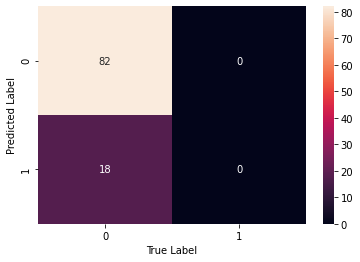

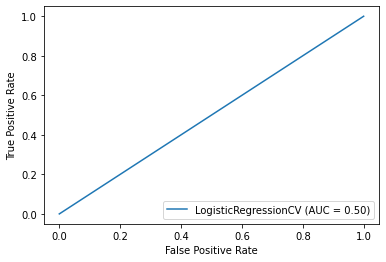

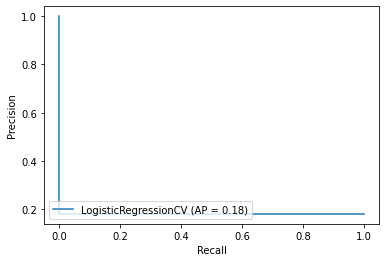

In [ ]:
small_train_ref_data = train_ref_data.sample(1000)
small_training_loader = LandsatViirs(
    df=small_train_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
small_dev_ref_data = dev_ref_data.sample(100)
small_dev_loader = LandsatViirs(
    df=small_dev_ref_data, 
    viirs_transform=viirs_transform,
    landsat_transform=landsat_transform
)
results, _, _ = conved_for_prediction(
    small_training_loader,
    small_dev_loader,
    Ytrain_class[small_train_ref_data.index],
    Ydev_class[small_dev_ref_data.index],
    n_components=64,
    lr=2e-3,
    kkl=1,
    kv=1,
    path="ConvVED_test_class.pt",
    batch_size=512,
    epochs=1,
    task='classification',
    verbose=True
)

### Hyperparameter Tuning for Classification


Using Convolutional VED
64 Components
0.002 Learning Rate
1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 150.0137, dev loss: 79.5176
Epoch: 2, train loss: 71.9281, dev loss: 78.9167
Epoch: 3, train loss: 67.1441, dev loss: 64.7570
Epoch: 4, train loss: 63.1407, dev loss: 60.4290
Epoch: 5, train loss: 60.2292, dev loss: 60.9428
Epoch: 6, train loss: 58.4915, dev loss: 59.0903
Epoch: 7, train loss: 57.8445, dev loss: 58.7323
Epoch: 8, train loss: 57.2292, dev loss: 56.8077
Epoch: 9, train loss: 56.0285, dev loss: 60.7929
Epoch: 10, train loss: 56.3373, dev loss: 56.4590

Training Logistic Regression

{'F1': 0.05535055350553505, 'l1_ratio': 0.99, 'C': 10.0, 'n_nonzero_weights': 11, 'accuracy': 0.7698876404494382, 'precision': 0.5172413793103449, 'recall': 0.029239766081871343}
There are 11 non-zero weights in the logistic regression model.


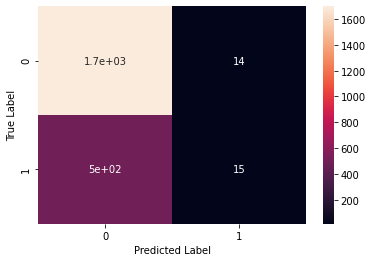

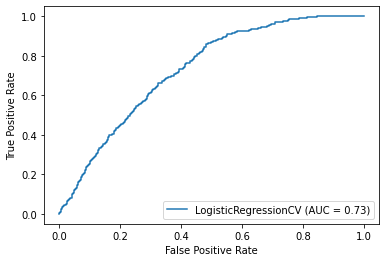

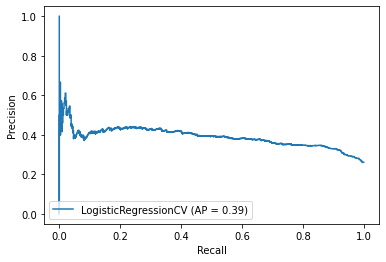


Using Convolutional VED
128 Components
0.002 Learning Rate
1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 158.5415, dev loss: 89.5574
Epoch: 2, train loss: 74.9707, dev loss: 71.7357
Epoch: 3, train loss: 67.9382, dev loss: 66.8062
Epoch: 4, train loss: 64.4644, dev loss: 64.7726
Epoch: 5, train loss: 62.5660, dev loss: 61.2974
Epoch: 6, train loss: 60.0238, dev loss: 61.8434
Epoch: 7, train loss: 58.7959, dev loss: 59.0012
Epoch: 8, train loss: 57.9803, dev loss: 58.5836
Epoch: 9, train loss: 57.2306, dev loss: 59.8180
Epoch: 10, train loss: 56.9256, dev loss: 58.7162

Training Logistic Regression

{'F1': 0.01890359168241966, 'l1_ratio': 1, 'C': 10.0, 'n_nonzero_weights': 20, 'accuracy': 0.7667415730337078, 'precision': 0.3125, 'recall': 0.009746588693957114}
There are 20 non-zero weights in the logistic regression model.


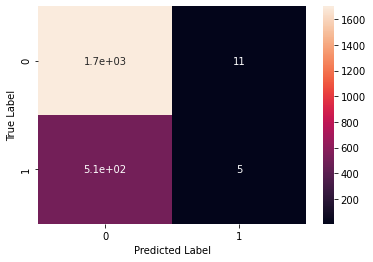

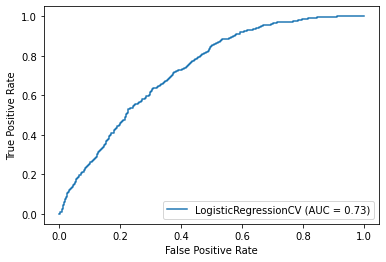

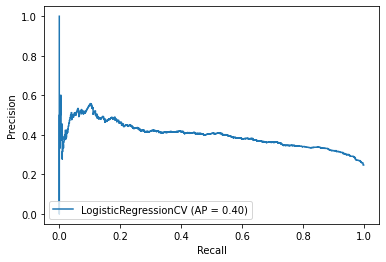


Using Convolutional VED
256 Components
0.002 Learning Rate
1 KL Divergence Regularizer
1 Latent Variance Regularizer
512 Batch Size

Epoch: 1, train loss: 131.6445, dev loss: 77.3386
Epoch: 2, train loss: 70.2562, dev loss: 67.2004
Epoch: 3, train loss: 64.6891, dev loss: 64.9266
Epoch: 4, train loss: 62.2750, dev loss: 62.1250
Epoch: 5, train loss: 60.0143, dev loss: 62.0617
Epoch: 6, train loss: 59.8794, dev loss: 64.8546
Epoch: 7, train loss: 60.0956, dev loss: 59.6970
Epoch: 8, train loss: 58.4492, dev loss: 59.3646
Epoch: 9, train loss: 58.7594, dev loss: 60.7501
Epoch: 10, train loss: 58.9654, dev loss: 59.3250

Training Logistic Regression



KeyboardInterrupt: ignored

In [ ]:
# Hyperparameter Search Space
n_components_cands = [64, 128, 256, 512]
lr_cands = [2e-3]
kkl = 1
kv = 1

results_set = []
best_score = 0
i = -1

# Grid Search
for n_components in n_components_cands:
  for lr in lr_cands:
    i += 1
    results, cved, logit = conved_for_prediction(
        training_loader,
        dev_loader,
        Ytrain_class,
        Ydev_class,
        n_components=n_components,
        task='classification',
        lr=lr,
        kkl=kkl,
        kv=kv,
        path=f"ConvVED_class{i}.pt",
        batch_size=512,
        verbose=True
    )
    results.update({
        "model_index" : i,
        "n_components" : n_components,
        "learning_rate" : lr,
        "kkl" : kkl,
        "kv" : kv
    })
    results_set.append(results)
    if results['F1'] > best_score:
      best_score = results['F1']
      best_model = {
          'cved' : cved,
          'logit' : logit
      }
      best_i = i

### Results

In [ ]:
results = pd.DataFrame(results_set)
results.sort_values(by="F1", ascending=False)

,F1,l1_ratio,C,n_nonzero_weights,accuracy,precision,recall,model_index,n_components,learning_rate,kkl,kv
0,0.055351,0.99,10.0,11,0.769888,0.517241,0.029240,0,64,0.002,1,1
1,0.018904,1.00,10.0,20,0.766742,0.312500,0.009747,1,128,0.002,1,1


In [ ]:
results.to_csv("grid_search_conved_classification.csv")

### Poverty Classificatoin

TEST ACCURACY: 0.7536407766990292
TEST PRECISION: 0.5769230769230769
TEST RECALL: 0.024469820554649267
TEST F1: 0.046948356807511735


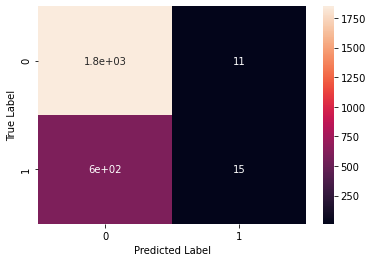

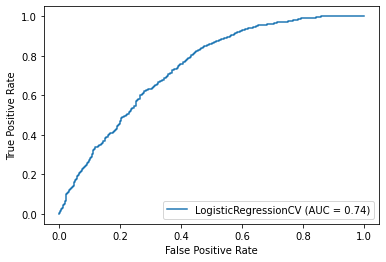

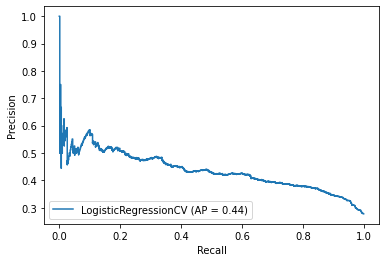

In [ ]:
test_features = best_model['cved'].transform(
    test_loader
)
TEST_PREDICTIONS = best_model['logit'].predict(
    test_features
)

ACCURACY = metrics.accuracy_score(Ytest_class, TEST_PREDICTIONS)
PRECISION = metrics.precision_score(Ytest_class, TEST_PREDICTIONS, average='binary')
RECALL = metrics.recall_score(Ytest_class, TEST_PREDICTIONS, average='binary')
F1 = metrics.f1_score(Ytest_class, TEST_PREDICTIONS, average='binary')

print(f"==================\nTEST ACCURACY: {ACCURACY}")
print(f"==================\nTEST PRECISION: {PRECISION}")
print(f"==================\nTEST RECALL: {RECALL}")
print(f"==================\nTEST F1: {F1}")

# utils.confusion_matrix(Ydev, Ydev_pred)
confusion_matrix(Ytest_class, TEST_PREDICTIONS)
utils.roc_auc(best_model['logit'], test_features, Ytest_class)
utils.precision_recall(best_model['logit'], test_features, Ytest_class)


### Optimizing Probability Threshold

Threshold 0.05, F1 0.428, Accuracy 0.391, Precision 0.273, Recall 0.990
Threshold 0.10, F1 0.448, Accuracy 0.457, Precision 0.293, Recall 0.957
Threshold 0.15, F1 0.474, Accuracy 0.528, Precision 0.319, Recall 0.924
Threshold 0.20, F1 0.492, Accuracy 0.585, Precision 0.343, Recall 0.871
Threshold 0.25, F1 0.484, Accuracy 0.625, Precision 0.354, Recall 0.762
Threshold 0.30, F1 0.478, Accuracy 0.667, Precision 0.375, Recall 0.661
Threshold 0.35, F1 0.444, Accuracy 0.703, Precision 0.391, Recall 0.513
Threshold 0.40, F1 0.375, Accuracy 0.739, Precision 0.419, Recall 0.339
Threshold 0.45, F1 0.215, Accuracy 0.758, Precision 0.425, Recall 0.144
Threshold 0.50, F1 0.055, Accuracy 0.770, Precision 0.517, Recall 0.029
Threshold 0.55, F1 0.000, Accuracy 0.769, Precision 0.000, Recall 0.000
Threshold 0.60, F1 0.000, Accuracy 0.769, Precision 0.000, Recall 0.000
Threshold 0.65, F1 0.000, Accuracy 0.769, Precision 0.000, Recall 0.000
Threshold 0.70, F1 0.000, Accuracy 0.769, Precision 0.000, Recal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



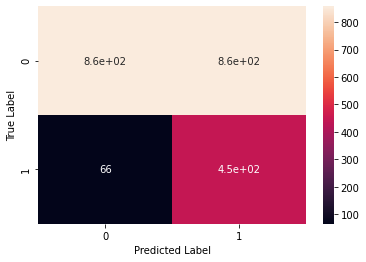

In [ ]:
dev_features = best_model['cved'].transform(
    dev_loader
)
dev_probabilities = best_model['logit'].predict_proba(dev_features)[:,1]

best_f1 = 0
threshold = 0

while threshold < 1:
    threshold += 0.05
    dev_predictions = adjusted_classes(dev_probabilities, threshold)
    f1 = metrics.f1_score(Ydev_class, dev_predictions, average='binary')
    t_accuracy = metrics.accuracy_score(Ydev_class, dev_predictions)
    t_precision = metrics.precision_score(Ydev_class, dev_predictions, average='binary')
    t_recall = metrics.recall_score(Ydev_class, dev_predictions, average='binary')
    print('Threshold %.2f, F1 %.3f, Accuracy %.3f, Precision %.3f, Recall %.3f' %
          (threshold, f1, t_accuracy, t_precision, t_recall))
    if f1 > best_f1:
        BEST_THRESHOLD = threshold
        best_f1 = f1
        best_predictions = dev_predictions
        best_accuracy = t_accuracy
        best_precision = t_precision
        best_recall = t_recall

print(f"==================\nBEST DEV THRESHOLD: {BEST_THRESHOLD}")
print(f"==================\n\tACCURACY: {best_accuracy}")
print(f"==================\n\tPRECISION: {best_precision}")
print(f"==================\n\tRECALL: {best_recall}")
print(f"==================\n\tF1: {best_f1}")

# utils.confusion_matrix(Ydev, Ydev_pred)
confusion_matrix(Ydev_class, best_predictions)


BEST TEST ACCURACY: 0.5792880258899676
BEST TEST PRECISION: 0.3573814295257181
BEST TEST RECALL: 0.8727569331158238
BEST TEST F1: 0.5071090047393365


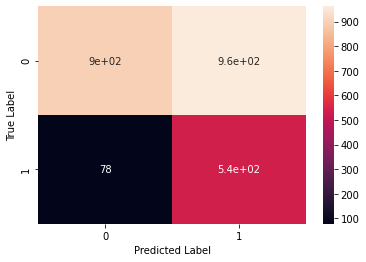

In [ ]:
TEST_PROBABILITIES = best_model['logit'].predict_proba(test_features)[:,1]
BEST_TEST_PREDICTIONS = adjusted_classes(
    TEST_PROBABILITIES, 
    BEST_THRESHOLD
)

ADJ_ACCURACY = metrics.accuracy_score(Ytest_class, BEST_TEST_PREDICTIONS)
ADJ_PRECISION = metrics.precision_score(Ytest_class, BEST_TEST_PREDICTIONS, average='binary')
ADJ_RECALL = metrics.recall_score(Ytest_class, BEST_TEST_PREDICTIONS, average='binary')
ADJ_F1 = metrics.f1_score(Ytest_class, BEST_TEST_PREDICTIONS, average='binary')

print(f"==================\nBEST TEST ACCURACY: {ADJ_ACCURACY}")
print(f"==================\nBEST TEST PRECISION: {ADJ_PRECISION}")
print(f"==================\nBEST TEST RECALL: {ADJ_RECALL}")
print(f"==================\nBEST TEST F1: {ADJ_F1}")

# utils.confusion_matrix(Ydev, Ydev_pred)
confusion_matrix(Ytest_class, BEST_TEST_PREDICTIONS)

### Save

In [ ]:
from google.colab import files

with open('final_classification_results.json', 'w') as f:
  FINAL = {
      "ACCURACY" : ACCURACY,
      "PRECISION" : PRECISION,
      "RECALL" : RECALL,
      "F1" : F1
  }
  json.dump(FINAL, f)
  
files.download("grid_search_conved_classification.csv")
files.download(f"ConvVED_class{best_i}.pt")
files.download("final_classification_results.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('adjusted_classification_results.json', 'w') as f:
  ADJUSTED_FINAL = {
      "PROBABILITY THRESHOLD" : BEST_THRESHOLD,
      "ACCURACY" : ADJ_ACCURACY,
      "PRECISION" : ADJ_PRECISION,
      "RECALL" : ADJ_RECALL,
      "F1" : ADJ_F1
  }
  json.dump(ADJUSTED_FINAL, f)
files.download('adjusted_classification_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>